# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345

In [2]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [3]:
# смотрим информацию о количестве и типе данных признаков
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [4]:
# проверим наличие дубликатов
df.duplicated().sum()

4

In [5]:
# удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
# удаляем признаки, не влияющих на целевой признак:
df.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures',
                    'PostalCode', 'LastSeen', 'RegistrationMonth'],
           axis=1,
           inplace=True)

display(df.head(1))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN


In [7]:
# переобразуем названия колонок в более привычный:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
display(df.head(1))


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN


In [8]:
print('Количество пропусков:')
display(df.isna().sum())

Количество пропусков:


price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

Большое количество пропусков, будем разбираться!

In [9]:
# выводим основные данные по числовым признакам
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0


Наблюдаем аномальные значения в признаках

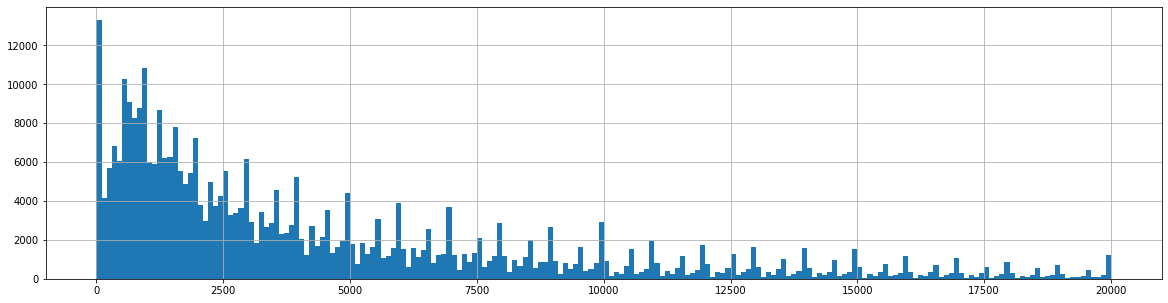

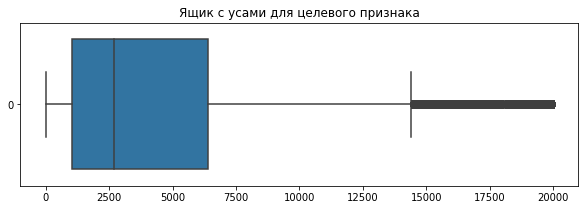

In [10]:
# выведем гистограмму и ящик с усами для целевого признака price: 
df.price.hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=df.price, orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

In [11]:
# на гистограмме и ящике с усами странные данные у нуля и длинный хвост возле 15000, смотрим квантили:
df.price.quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

In [12]:
# смотрим долю строк, где цена меньше 200 и больше 14600:
1 - df.query('200 <= price <= 14600').shape[0] / df.shape[0]

0.09908992140871697

In [13]:
# усечем в нужном диапазоне
df = df.query('200 <= price <= 14600').reset_index(drop=True)

In [14]:
# смотрим значения в registration_year:
df.registration_year.value_counts()

2000    22036
1999    21483
2005    20916
2001    19382
2003    19278
        ...  
1948        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 132, dtype: int64

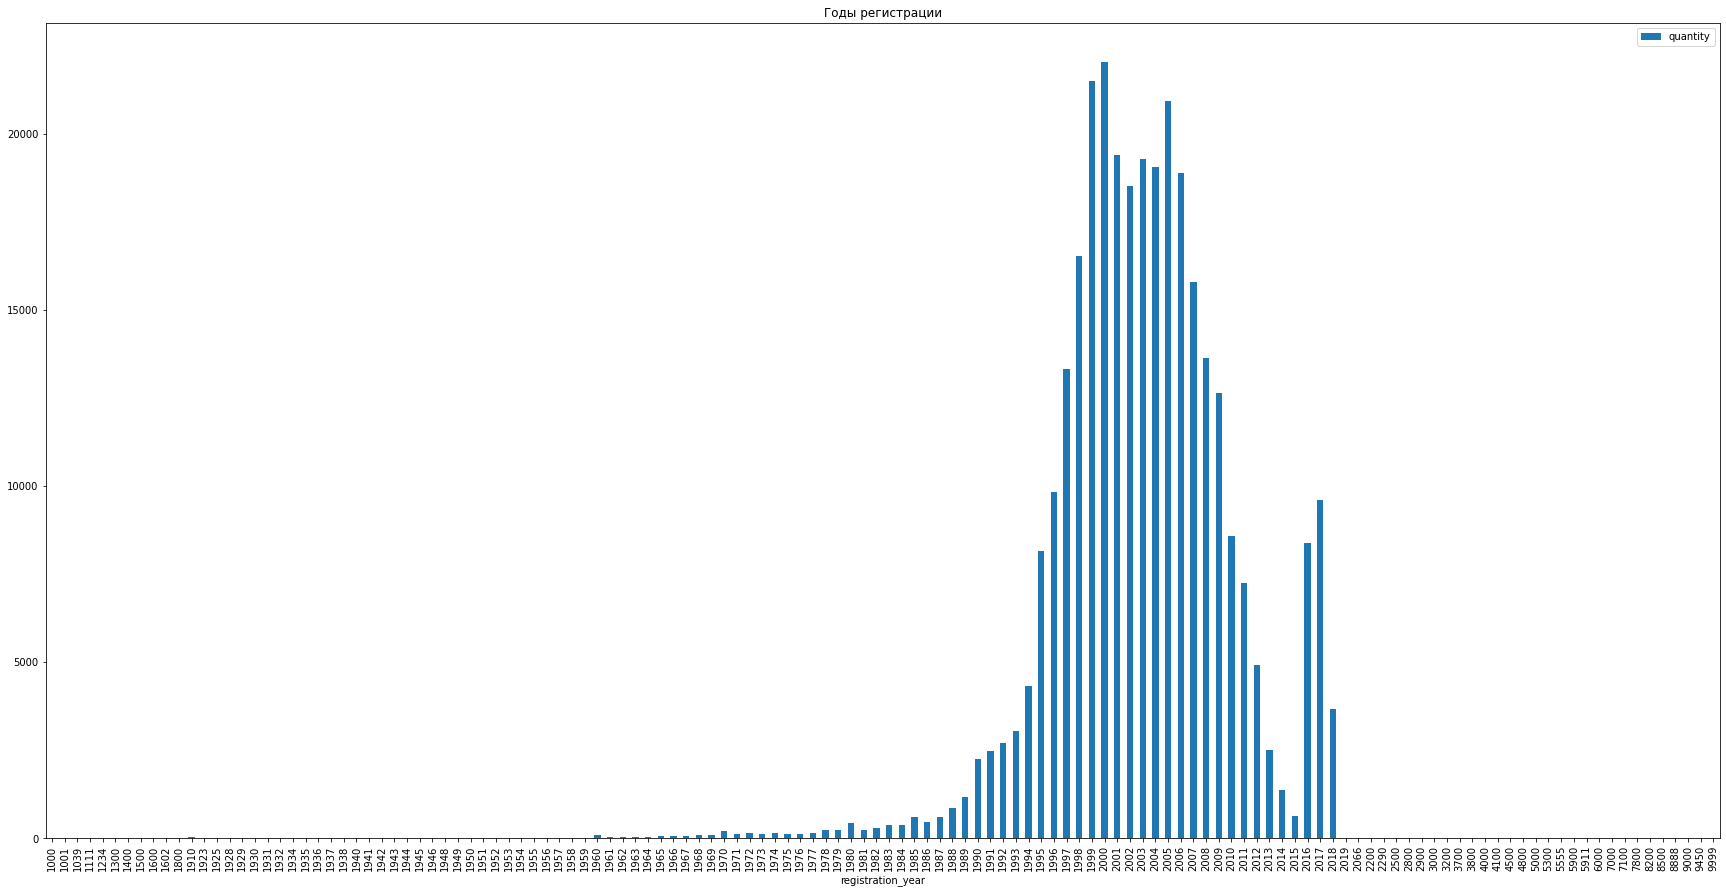

In [15]:
year = df.pivot_table(index='registration_year', values='brand', aggfunc='count')
year.columns = ['quantity']
year.plot.bar(figsize = (30,15))
plt.title('Годы регистрации')
plt.show()

In [16]:
df.registration_year.quantile([.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: registration_year, dtype: float64

In [17]:
# смотрим долю строк, где год меньше 1993 и больше 2016:
1 - df.query('1993 <= registration_year <= 2018').shape[0] / df.shape[0]

0.048566801670159254

In [18]:
df = df.query('1993 <= registration_year <= 2018').reset_index(drop=True)

Не понятно с чем связано резкое увеличение в 2016, 2017, 2018 регистрации, наваерное с увеличением продаж, не похоже на выброс. Оставим свежие данные, исключим аномалии.

In [19]:
df = df.query('10 <= power <= 2000').reset_index(drop=True)

Оставим автомобили с мощностью начиная с 10 л.с. до 2000 л.с.

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,273062.0,4176.028774,3573.164278,200.0,1300.0,2990.0,6200.0,14600.0
registration_year,273062.0,2003.808901,5.628864,1993.0,2000.0,2003.0,2007.0,2018.0
power,273062.0,118.468384,60.772388,10.0,75.0,109.0,143.0,2000.0
kilometer,273062.0,130769.806857,34514.011781,5000.0,125000.0,150000.0,150000.0,150000.0


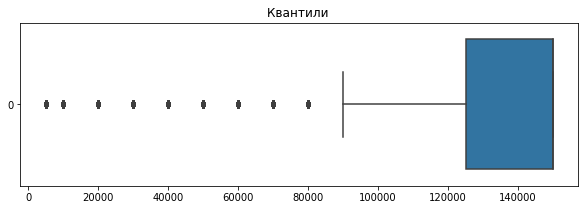

In [21]:
# выведем гистограмму и ящик с усами для километража: 
plt.figure(figsize=(10,3))
sns.boxplot(data=df.kilometer, orient='h')
plt.title('Квантили ')
plt.show()

В основном автомобили с большим километражом от 125000км до 150000км.

In [22]:
# провеим на неявные дубликаты признак brand
df.brand.value_counts()

volkswagen        58679
opel              31834
bmw               28577
mercedes_benz     23019
audi              22368
ford              19680
renault           13952
peugeot            9278
fiat               7474
seat               5832
skoda              4690
smart              4583
mazda              4534
citroen            4149
toyota             3853
nissan             3728
hyundai            2992
mini               2540
volvo              2524
mitsubishi         2377
honda              2268
kia                1994
alfa_romeo         1872
suzuki             1814
chevrolet          1258
chrysler           1101
sonstige_autos      999
dacia               807
daihatsu            599
subaru              575
jeep                452
saab                424
daewoo              413
rover               363
lancia              355
jaguar              346
land_rover          337
porsche             276
lada                134
trabant              12
Name: brand, dtype: int64

В признаке brand неявных дубликатов не выявлено

In [23]:
print('Количество пропусков:')
display(df.isna().sum())

Количество пропусков:


price                    0
vehicle_type         19660
registration_year        0
gearbox               5343
power                    0
model                10317
kilometer                0
fuel_type            17655
brand                    0
repaired             41877
dtype: int64

In [24]:
# для признака gearbox заменим NaN на 'auto', так как в основном машины с этим типом коробки передач:
df.fillna({'gearbox':'auto'}, inplace=True)

In [25]:
# заменим для обучения модели в gearbox значение auto на 1, manual - на 0:
df.loc[(df.gearbox == 'auto'), 'gearbox'] = 1   
df.loc[(df.gearbox == 'manual'), 'gearbox'] = 0
df.gearbox = df.gearbox.astype('int')

In [26]:
# для признака repaired заменим NaN на 'yes', так как в основном подержанная машина с пробегом была в ремонте:
df.fillna({'repaired':'yes'}, inplace=True)



In [27]:
# заменим для обучения модели в repaired значение yes на 1, no - на 0:
df.loc[(df.repaired == 'yes'), 'repaired'] = 1
df.loc[(df.repaired == 'no'), 'repaired'] = 0
df.repaired = df.repaired.astype('int')

In [28]:
# заменим NaN в признаке model на 'unknown', так как нет возожности восстановить данные другим способом:
df.fillna({'model':'unknown'}, inplace=True)
df.model.value_counts()

golf                  22652
3er                   15809
other                 15601
unknown               10317
polo                  10309
                      ...  
rangerover                2
range_rover_evoque        2
200                       1
gl                        1
serie_2                   1
Name: model, Length: 249, dtype: int64

In [29]:
# объединяем марку, модель в один столбец для удобства
df['model'] = + df['brand'] + ' ' + df['model'] 


In [30]:
# убираем лишний столбец в тестовых данных
df = df.drop(columns=['brand'])

In [31]:
# заменим NaN в признаке vehicle_type на 'unknown', так как нет возможности восстановить данные другим способом:
df.fillna({'vehicle_type':'unknown'}, inplace=True)
df.vehicle_type.value_counts()



sedan          72544
small          65871
wagon          54670
bus            23861
unknown        19660
convertible    15257
coupe          11001
suv             8172
other           2026
Name: vehicle_type, dtype: int64

In [32]:
# заменим NaN в признаке fuel_type на 'unknown', так как нет возможности восстановить данные другим способом:
df.fillna({'fuel_type':'unknown'}, inplace=True)
df.fuel_type.value_counts()



petrol      171138
gasoline     79023
unknown      17655
lpg           4497
cng            487
hybrid         157
electric        56
other           49
Name: fuel_type, dtype: int64

In [33]:
print('Количество пропусков:')
display(df.isna().sum())

Количество пропусков:


price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
repaired             0
dtype: int64

In [34]:
# уменьшим размерность хранения типа для ускорения работы с дата фреймом
df['repaired'] = pd.to_numeric(df['repaired'], downcast='integer')
df['gearbox'] = pd.to_numeric(df['gearbox'], downcast='integer')
df['registration_year'] = pd.to_numeric(df['registration_year'], downcast='integer')
df['power'] = pd.to_numeric(df['power'], downcast='integer')
df['kilometer'] = pd.to_numeric(df['kilometer'], downcast='integer')
df['price'] = pd.to_numeric(df['price'], downcast='integer')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273062 entries, 0 to 273061
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              273062 non-null  int16 
 1   vehicle_type       273062 non-null  object
 2   registration_year  273062 non-null  int16 
 3   gearbox            273062 non-null  int8  
 4   power              273062 non-null  int16 
 5   model              273062 non-null  object
 6   kilometer          273062 non-null  int32 
 7   fuel_type          273062 non-null  object
 8   repaired           273062 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(3)
memory usage: 9.4+ MB


In [36]:
display(df.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,9800,suv,2004,1,163,jeep grand,125000,gasoline,1
1,1500,small,2001,0,75,volkswagen golf,150000,petrol,0
2,3600,small,2008,0,69,skoda fabia,90000,gasoline,0
3,650,sedan,1995,0,102,bmw 3er,150000,petrol,1
4,2200,convertible,2004,0,109,peugeot 2_reihe,150000,petrol,0


In [37]:
# выведем матрицу корреляций коэффициента Пирсона по целевому признаку
df.corr()['price']

price                1.000000
registration_year    0.512401
gearbox              0.191798
power                0.381141
kilometer           -0.341819
repaired            -0.250116
Name: price, dtype: float64

### Вывод

Предобработали данные:

- удалили дубликаты,
- убрали выбросы в признаках,
- заполнили пропуски в данных.

Наблюдаем закономерную корреляцию с признаками. Данные готовы к обучению.

## Обучение моделей

In [38]:
# выделяем целевой признак и признаки:
target = df["price"]
features = df.drop("price", axis=1)


In [39]:
# выделяем 75% данных для обучающей выборки, остальные данные для тестовой
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = RANDOM_STATE)

In [40]:
# кодируем категориальные признаки:
encoder = OrdinalEncoder(handle_unknown='ignore')

features_train_ord = features_train[["vehicle_type","fuel_type","model"]]
features_train_ord = pd.DataFrame(encoder.fit_transform(features_train_ord),
                                 columns=features_train_ord.columns,
                                 index=features_train_ord.index)




In [41]:
features_test_ord = features_test[["vehicle_type","fuel_type","model"]]
features_test_ord = pd.DataFrame(encoder.transform(features_test_ord),
                                 columns=features_test_ord.columns,
                                 index=features_test_ord.index)

In [42]:
features_train = features_train.drop(columns=["vehicle_type","fuel_type","model"])


In [43]:
features_train = pd.merge(
    features_train, features_train_ord, left_index=True, right_index=True)


In [44]:
features_test = features_test.drop(columns=["vehicle_type","fuel_type","model"])

In [45]:
features_test = pd.merge(features_test, features_test_ord, left_index=True, right_index=True)


------------------------------------------------

Модель RandomForestRegressor

In [46]:
# подбираем гиперпарамаметры для модели случайного леса
param = {'max_depth': range(1,21,5),
         'n_estimators':range(1,10,1),
          'min_samples_leaf': range (1,8)}
grid_search_rfr = GridSearchCV(
     RandomForestRegressor(
         random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'neg_root_mean_squared_error')


In [47]:
%%time

# инициализируем модель случайного леса
grid_search_rfr.fit(features_train, target_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits
CPU times: user 8min 38s, sys: 633 ms, total: 8min 39s
Wall time: 8min 42s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 21, 5),
                         'min_samples_leaf': range(1, 8),
                         'n_estimators': range(1, 10)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [48]:
%%time

# измеряем время предсказания для модели случайный лес
predictions = grid_search_rfr.predict(features_train)

CPU times: user 378 ms, sys: 4 ms, total: 382 ms
Wall time: 398 ms


In [49]:
# выводим модель случайного леса с лучшими гиперпараметрами
grid_search_rfr.best_estimator_


RandomForestRegressor(max_depth=16, min_samples_leaf=2, n_estimators=9,
                      random_state=12345)

In [50]:
# RMSE для лучшей модели
grid_search_rfr_score = (grid_search_rfr.best_score_*-1).round()
print(grid_search_rfr_score)

1371.0


----------------------------------------------------------------

Модель CatBoostRegressor

In [51]:
# подбираем гиперпарамаметры для модели CatBoostRegressor
param = {'max_depth': range(1,21,10),
         'learning_rate':range(1,2,1)}
grid_search_cbr = GridSearchCV(
     CatBoostRegressor(
         random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'neg_root_mean_squared_error')


In [52]:
%%time

grid_search_cbr.fit(features_train, target_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 2916.6707182	total: 82.1ms	remaining: 1m 22s
1:	learn: 2646.3106373	total: 97.6ms	remaining: 48.7s
2:	learn: 2531.4760800	total: 109ms	remaining: 36.3s
3:	learn: 2383.9856336	total: 119ms	remaining: 29.7s
4:	learn: 2337.2872572	total: 131ms	remaining: 26s
5:	learn: 2292.3886054	total: 141ms	remaining: 23.4s
6:	learn: 2225.5022429	total: 153ms	remaining: 21.6s
7:	learn: 2173.6518504	total: 170ms	remaining: 21s
8:	learn: 2135.2061245	total: 182ms	remaining: 20s
9:	learn: 2113.0896033	total: 193ms	remaining: 19.1s
10:	learn: 2095.6056023	total: 204ms	remaining: 18.3s
11:	learn: 2078.9558675	total: 215ms	remaining: 17.7s
12:	learn: 2057.4122508	total: 226ms	remaining: 17.1s
13:	learn: 2044.1822434	total: 236ms	remaining: 16.6s
14:	learn: 2018.6020099	total: 247ms	remaining: 16.2s
15:	learn: 2002.8274693	total: 258ms	remaining: 15.9s
16:	learn: 1986.3865850	total: 272ms	remaining: 15.7s
17:	learn: 1977.2302398	total: 287ms

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f453470a760>,
             param_grid={'learning_rate': range(1, 2),
                         'max_depth': range(1, 21, 10)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [53]:
# выводим модель CatBoostRegressor с лучшими гиперпараметрами
grid_search_cbr.best_params_

{'learning_rate': 1, 'max_depth': 11}

In [54]:
# RMSE для лучшей модели
grid_search_cbr_score = (grid_search_cbr.best_score_*-1).round()
print(grid_search_cbr_score)

1397.0


In [55]:
%%time

# измеряем время предсказания для модели CatBoostRegressor
predictions = grid_search_cbr.predict(features_train)

CPU times: user 981 ms, sys: 3.99 ms, total: 985 ms
Wall time: 991 ms


-----

Модель LightGBMRegressor

Выберем параметры попроще, чтобы не тратить много времени на поиск оптимальных параметров

In [56]:
# подбираем гиперпарамаметры для модели LightGBMRegressor
param = {'num_leaves': range(1,3,1),
         'max_depth': range (1,3,1)}
grid_search_lgr = GridSearchCV(
     LGBMRegressor(
         random_state=RANDOM_STATE), param, verbose=1, cv=3, scoring = 'neg_root_mean_squared_error')



In [57]:
%%time

grid_search_lgr.fit(features_train, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



CPU times: user 8min, sys: 952 ms, total: 8min 1s
Wall time: 8min 2s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 3), 'num_leaves': range(1, 3)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [58]:
# выводим модель LightGBMRegressor с лучшими гиперпараметрами
grid_search_lgr.best_params_

{'max_depth': 1, 'num_leaves': 2}

In [59]:
# RMSE для лучшей модели
grid_search_lgr_score = (grid_search_lgr.best_score_*-1).round()
print(grid_search_lgr_score)

1982.0


In [60]:
%%time

# измеряем время предсказания для модели LightGBMRegressor
predictions = grid_search_lgr.predict(features_train)

CPU times: user 595 ms, sys: 0 ns, total: 595 ms
Wall time: 538 ms


### Вывод

Обучили 3 модели - RandomForestRegressor, CatBoostRegressor и LGBMRegressor со сменой гиперпараметров. Анализ и выбор лучшей модели будет приведен в сводной таблице в следующей главе.

## Анализ моделей

In [66]:
# сводная таблица по показателям RMSE, время обучения модели и время предсказания модели:
index = ['RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

data = {'RMSE':[grid_search_rfr_score,
                grid_search_cbr_score,
                grid_search_lgr_score],
        
        'Время обучения модели':[8.42, 
                                 4.11,
                                 8.02],
        
        'Время предсказания модели':[0.01, 
                                 0.01,
                                 0.01],   
       }

data = pd.DataFrame(data=data, index=index)


data.sort_values(by = 'RMSE', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели
RandomForestRegressor,1371.0,8.42,0.01
CatBoostRegressor,1397.0,4.11,0.01
LGBMRegressor,1982.0,8.02,0.01


Лучшей моделью по всем параметрам является CatBoostRegressor, время предсказания не будет сильно отличаться между представленными моделями.

In [62]:
# тестирование лучшей модели на тестовой выборке 
model_cbr = CatBoostRegressor(learning_rate=1, max_depth=7, random_state=RANDOM_STATE)
model_cbr.fit(features_train, target_train)

0:	learn: 2072.6311559	total: 41.9ms	remaining: 41.9s
1:	learn: 1879.5539330	total: 70.5ms	remaining: 35.2s
2:	learn: 1789.3180609	total: 101ms	remaining: 33.7s
3:	learn: 1728.7717242	total: 144ms	remaining: 36s
4:	learn: 1673.3154457	total: 172ms	remaining: 34.3s
5:	learn: 1627.1630182	total: 203ms	remaining: 33.7s
6:	learn: 1588.4471852	total: 247ms	remaining: 35s
7:	learn: 1568.2178391	total: 274ms	remaining: 33.9s
8:	learn: 1555.0325460	total: 302ms	remaining: 33.2s
9:	learn: 1534.6190508	total: 346ms	remaining: 34.2s
10:	learn: 1520.7506209	total: 374ms	remaining: 33.6s
11:	learn: 1508.8879352	total: 402ms	remaining: 33.1s
12:	learn: 1499.5036222	total: 449ms	remaining: 34.1s
13:	learn: 1488.3031882	total: 478ms	remaining: 33.7s
14:	learn: 1479.1005903	total: 517ms	remaining: 34s
15:	learn: 1470.8426604	total: 551ms	remaining: 33.9s
16:	learn: 1466.4401829	total: 577ms	remaining: 33.4s
17:	learn: 1461.2273514	total: 611ms	remaining: 33.3s
18:	learn: 1456.7575077	total: 650ms	remai

In [63]:
predictions = model_cbr.predict(features_test)

In [64]:
rmse = ((mean_squared_error(target_test, predictions)) ** 0.5).round()

In [65]:
print("RMSE для CatBoostRegressor на тестовой выборке", rmse)

RMSE для CatBoostRegressor на тестовой выборке 1328.0


#### Вывод


В ходе работы было выполнено:

 1. Загружены данные и проведена предобработка.
 2. Выполнено сравнение 3-х моделей RandomForestRegressor, CatBoostRegressor и LGBMRegressor с использованием различных наборов гиперпараметров.
 3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.
 
Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать CatBoostRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры. Все остальные показали себя в целом хуже. RMSE для модели CatBoostRegressor на тестовой выборке 1328. Для заказчика однозначно рекомендую использовать эту модель для определения цены автомобиля на вторичном рынке.



